In [1]:
from vectorhash_imported import *
from vectorhash_convered import *
from nd_scaffold import GridScaffold
import math
from scipy.stats import norm


lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]
percent_nonzero_relu = 0.5  #
W_gh_var = 1
sparse_initialization = 0.1
T = 0.1
W_hg_std = math.sqrt(W_gh_var)
W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
h_normal_mean = len(lambdas) * W_hg_mean
h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
    1 - percent_nonzero_relu
)
num_imgs = 500

print(
    percent_nonzero_relu, W_hg_mean, W_hg_std, h_normal_mean, h_normal_std, relu_theta
)

GS = GridScaffold(
    shapes=shapes,
    N_h=2000,
    input_size=784,
    device=None,
    learned_pseudo="bidirectional",
    hidden_layer_factor=0,
    stationary=True,
    epsilon_sh=0.0001,
    epsilon_hs=255,
    sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
        sparsity=sparse_initialization, device="cpu"
    ),
    # relu_theta=0,
    # sparse_matrix_initializer=SparseMatrixByScalingInitializer(
    #     scale=W_hg_std, mean=W_hg_mean, device="cpu"
    # ),
    relu_theta=relu_theta,
    T=T,
    # h fix
    calculate_update_scaling_method="n_h",
    use_h_fix=False,  # true if norm scaling, false 25/32, true 21/32 11/32
    h_normal_mean=h_normal_mean,
    h_normal_std=h_normal_std,
    # epsilon=0.01,
    scaling_updates=False,  # only relevant when using hebbian false 21/32, true 15/32 7/32
    sanity_check=False,
    # dream_fix=1,
    # zero_tol=1,
)

0.5 -0.0 1.0 -0.0 1.7320508075688772 0.0
UPDATE SCALING BY SCHWARZ ERROR False
module shapes:  [(3, 3), (4, 4), (5, 5)]
N_g     :  50
N_patts :  3600
N_h     :  2000


In [2]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np

dataset = load_mnist_dataset()
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=False,
    noise_level="none",
    across_dataset=True,
)

# REMOVE THESE LINES
# data = data.float() / 255.0
# noisy_data = noisy_data.float() / 255.0

# data, noisy_data = prepare_data_random(noise_scale=0)
v = spacefillingcurve(shapes)

g_positions, g_positions2, g_points, g_points_2 = GS.learn_path(
    observations=data, velocities=v[: len(data)]
)
recalled_imgs = GS.recall(noisy_data)
similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
mse = torch.nn.functional.mse_loss(data, recalled_imgs, reduction="none")
print(mse.mean())
print(similarity.mean())
for i in range(min(num_imgs, 5)):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    im1 = ax[0].imshow(data[(-i)].reshape(28, 28), cmap="gray")
    ax[0].set_title("Original")
    im2 = ax[1].imshow((recalled_imgs[(-i)]).reshape(28, 28), cmap="gray")
    title = f"Recalled similarity: {similarity[(-i)].item()}"
    ax[1].set_title(title)

    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
labels = dataset.train_labels[:num_imgs]
unique_labels = np.unique(labels)
similarity_per_label = []
for label in unique_labels:
    idx = labels == label
    similarity_per_label.append(similarity[idx].mean())
# make bars not overlap
label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.bar(unique_labels, similarity_per_label, label=label)
ax.set_title("Similarity per label")
ax.set_xlabel("Label")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.tight_layout()
plt.show()

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)

label = f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
ax.plot(similarity, label=label)
ax.set_title("Similarity per image")
ax.set_xlabel("Image")
ax.set_ylabel("Similarity")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()

ImportError: cannot import name 'spacefillingcurve' from 'vectorhash_functions' (/Users/jonathanlamontange-kratz/Documents/GitHub/rl-stuff/vectorhash/vectorhash_functions.py)

tensor(32.1762)


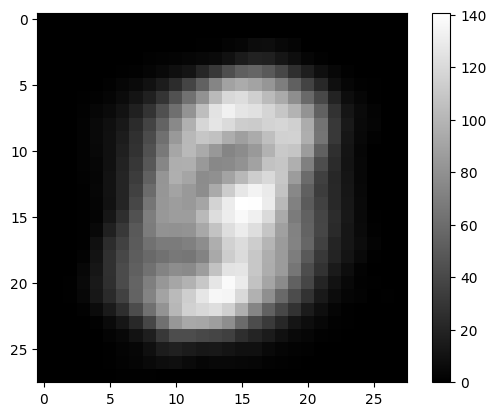

In [ ]:
plt.imshow(data.mean(dim=0).reshape(28, 28), cmap="gray")
plt.colorbar()
print(data.mean())

In [ ]:
from vectorhash_functions import *

mod_n_positions = []
mod_n_positions_2 = []
mod_n_states = []
mod_n_states_2 = []

# assume shapes are squares

for _ in lambdas:
    mod_n_positions.append(list())
    mod_n_positions_2.append(list())
    mod_n_states.append(list())
    mod_n_states_2.append(list())

for g in g_positions:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_positions2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_positions_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

for g in g_points_2:
    pos = 0
    for i, l in enumerate(lambdas):
        mod_n = g[pos : pos + l**2]
        mod_n_states_2[i].append(ConvertToXYNew(mod_n, (l, l)))
        pos += l**2

500
499
500
499


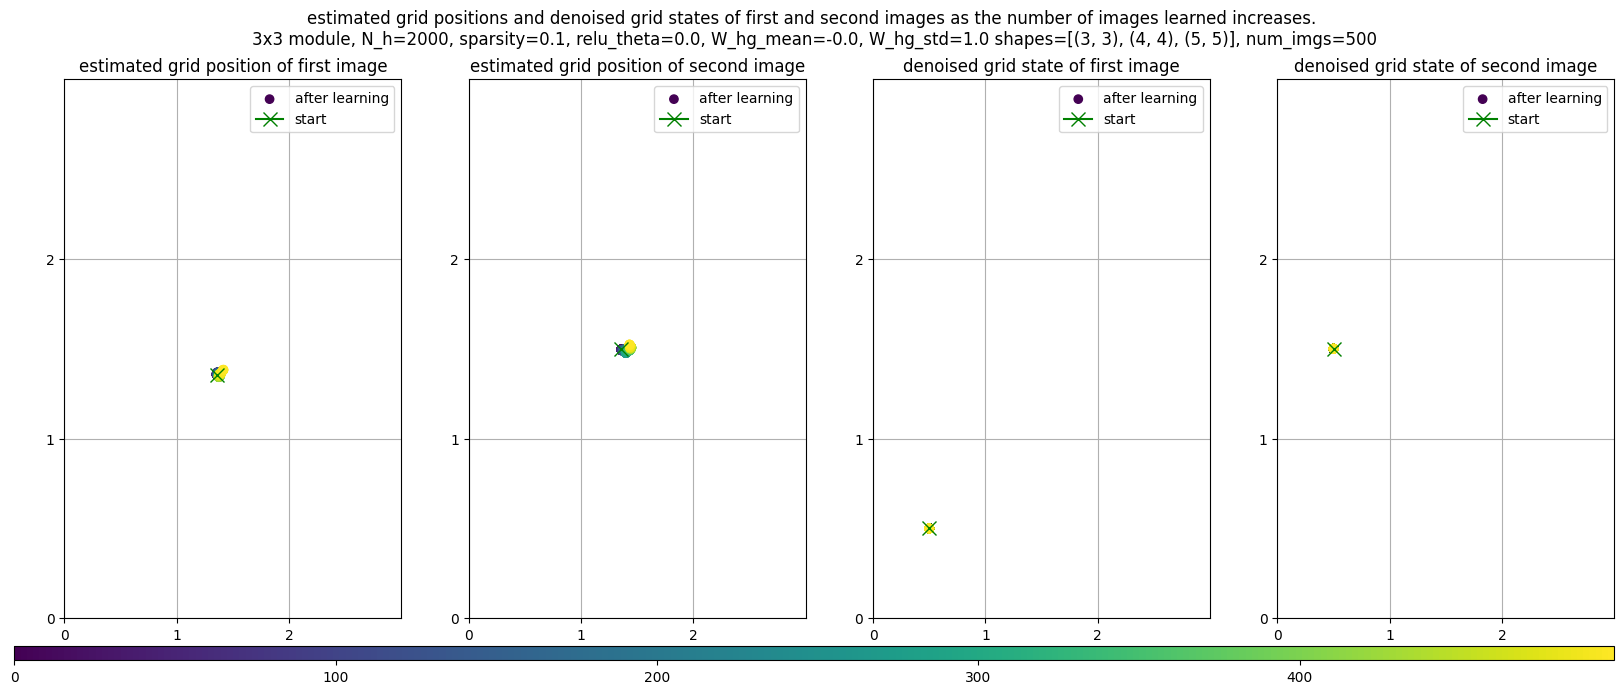

500
499
500
499


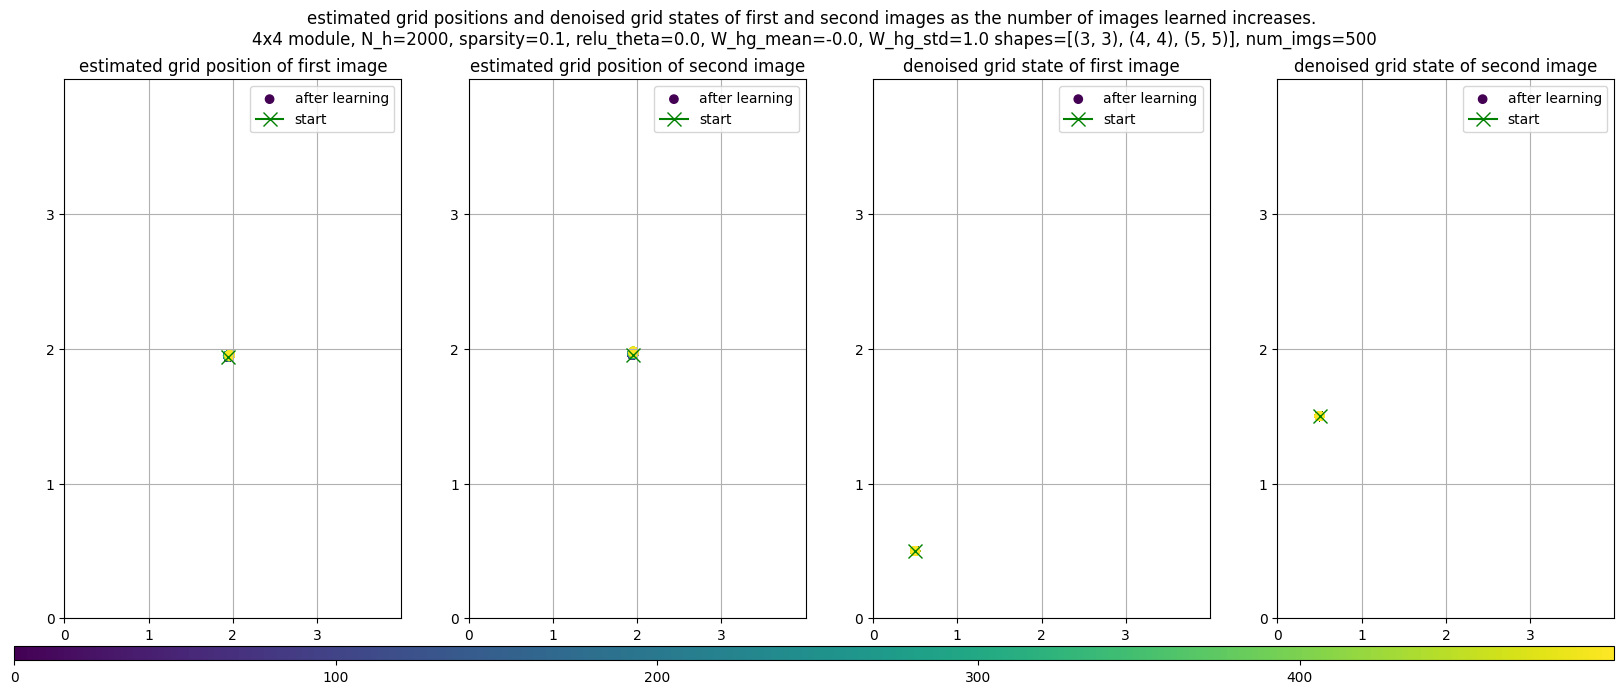

500
499
500
499


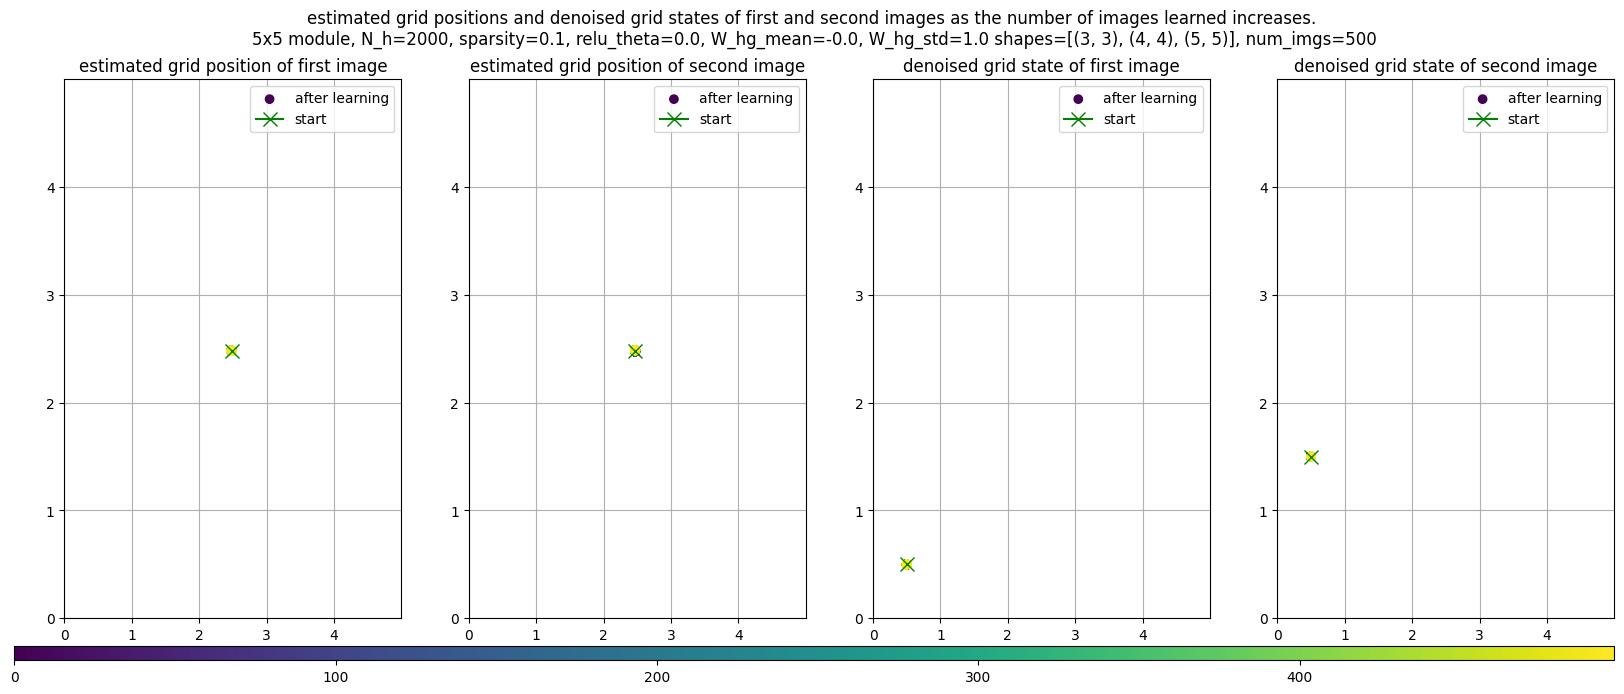

In [ ]:
for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l), (l, l), (l, l)],
        points_lists=[
            mod_n_positions[i],
            mod_n_positions_2[i],
            mod_n_states[i],
            mod_n_states_2[i],
        ],
        first_points=[
            mod_n_positions[i][0],
            mod_n_positions_2[i][0],
            mod_n_states[i][0],
            mod_n_states_2[i][0],
        ],
        titles=[
            f"estimated grid position of first image",
            f"estimated grid position of second image",
            f"denoised grid state of first image",
            f"denoised grid state of second image",
        ],
        main_title=f"estimated grid positions and denoised grid states of first and second images as the number of images learned increases. \n{l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta, 2)}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std} shapes={shapes}, num_imgs={num_imgs}",
    )

In [ ]:
from vectorhash_functions import spacefillingcurve
from data_utils import prepare_data, load_mnist_dataset
import torch
from graph_utils import print_imgs_side_by_side_on_top

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(lambda x: x.flatten())]
)

dataset = torchvision.datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

num_imgs = 201
data, noisy_data = prepare_data(
    dataset,
    num_imgs=num_imgs,
    preprocess_sensory=True,
    noise_level="none",
    use_fix=True,
)
LAST_N_IMGS = 10
# data, noisy_data = prepare_data_random(noise_scale=0)
params = [0.01, 0.001, 0.0001, 0.01, 0.1, 1]
sims = []
fixed = []
v = spacefillingcurve(shapes)

lambdas = [3, 4, 5]
shapes = [(i, i) for i in lambdas]
for i in params:
    percent_nonzero_relu = 0.02
    W_gh_var = 1
    sparse_initialization = 0.8
    T = i
    W_hg_std = math.sqrt(W_gh_var)
    W_hg_mean = -W_hg_std * norm.ppf(1 - percent_nonzero_relu) / math.sqrt(len(lambdas))
    h_normal_mean = len(lambdas) * W_hg_mean
    h_normal_std = math.sqrt(len(lambdas)) * W_hg_std
    relu_theta = math.sqrt((1 - sparse_initialization) * len(lambdas)) * norm.ppf(
        1 - percent_nonzero_relu
    )

    print(
        percent_nonzero_relu,
        W_hg_mean,
        W_hg_std,
        h_normal_mean,
        h_normal_std,
        relu_theta,
    )

    GS = GridScaffold(
        shapes=shapes,
        N_h=1700,
        input_size=784,
        h_normal_mean=h_normal_mean,
        h_normal_std=h_normal_std,
        device=None,
        sparse_matrix_initializer=SparseMatrixBySparsityInitializer(
            sparsity=sparse_initialization, device="cpu"
        ),
        relu_theta=relu_theta,  ######
        from_checkpoint=False,
        T=T,
        ratshift=False,
        pseudo_inverse=False,
        use_h_fix=False,
        learned_pseudo=False,
        epsilon=0.01,
        calculate_update_scaling_method="norm",
        sanity_check=False,
        calculate_g_method="fast",
        scaling_updates=True,
        dream_fix=10,
        slumber=False,
    )
    g_positions, g_positions2, g_points, g_points_2, imgs_fixed = GS.learn_path(
        observations=data, velocities=v[: len(data)]
    )
    recalled_imgs = GS.recall(noisy_data)
    similarity = torch.cosine_similarity(data, recalled_imgs, dim=1)
    sims.append(similarity)
    human_render = []
    for o in range(LAST_N_IMGS):
        a = []
        a.append(data[-(o + 1)].reshape(28, 28))
        a.append(recalled_imgs[-(o + 1)].reshape(28, 28))
        human_render.append(a)
    fixed.append(imgs_fixed)

    imgname = "images_graphs/TEMP_CHECK" + str(params.index(i)) + ".png"
    print_imgs_side_by_side_on_top(
        human_render,
        out=imgname,
        captions=["Original", "Recalled"],
        title="TEMP " + str(i),
    )
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    plt.show()


# BARCHART

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
# put legend outside of the plot
for i in range(len(sims)):
    similarity = sims[i]
    percent_nonzero_relu, sparse_initialization = params[i]

    labels = dataset.train_labels[: len(data)]
    unique_labels = np.unique(labels)
    similarity_per_label = []
    for label in unique_labels:
        idx = labels == label
        similarity_per_label.append(similarity[idx].mean())
    # make bars not overlap
    ax.bar(unique_labels, similarity_per_label, label="TEMP " + str(params[i]))
    ax.set_title("Similarity per label")
    ax.set_xlabel("Label")
    ax.set_ylabel("Similarity")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig("images_graphs/SLUMBER_LABELS.png")
plt.close(fig)

# LINEPLOT
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(18.5, 10.5, forward=True)
for i in range(len(sims)):
    similarity = sims[i]
    percent_nonzero_relu, sparse_initialization = params[i]
    label = (
        f"percent_nonzero_relu={percent_nonzero_relu} sparsity={sparse_initialization}"
    )
    ax.plot(similarity, label=label)
    ax.set_title("Similarity per image")
    ax.set_xlabel("Image")
    ax.set_ylabel("Similarity")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig("images_graphs/SLUMBER_SIMS.png")
plt.close(fig)

# LINEPLOT number of images fixed every 10 images
for i in range(len(fixed)):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18.5, 10.5, forward=True)
    ax.plot(fixed[i], label="TEMP " + str(params[i]))
    ax.set_title("Number of images fixed")
    ax.set_xlabel("DREAM SEQUENCE NUMBER")
    ax.set_ylabel("Fixed")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig.tight_layout()

plt.savefig("images_graphs/SLUMBER_FIXED" + str(params[i]) + ".png")
plt.close(fig)

IndentationError: unexpected indent (1571837118.py, line 96)

In [ ]:
point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )

In [ ]:
img = data[0]
recalled = GS.recall(img)
print(torch.cosine_similarity(img, recalled).mean())

plt.imshow(img.reshape(28, 28))
print(img.mean())
plt.colorbar()
plt.show()
plt.imshow((recalled).reshape(28, 28))
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(
    GS.sensory_from_hippocampal(GS.hippocampal_from_grid(GS.G[3200])).reshape(28, 28)
)
plt.colorbar()
plt.show()

In [ ]:
zero_indices = (dataset.train_labels == 0).nonzero().flatten()

data_by_class = dataset.data[zero_indices][:200].reshape(200, 784)
data_by_class = torch.tensor(data).float().to("cpu")
data_by_class = (data - data.mean(dim=0)) / (data.std(dim=0) + 1e-8)

plt.imshow(data_by_class[0].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class[1].reshape(28, 28), cmap="gray")
plt.show()
plt.imshow(data_by_class.mean(dim=0).reshape(28, 28), cmap="gray")
plt.show()

point_positions_n = []
point_states_n = []
for l in lambdas:
    point_positions_n.append([])
    point_states_n.append([])

for img in data_by_class:
    pos = GS.estimate_position(img)
    state = GS.denoise(
        GS.grid_from_hippocampal(GS.hippocampal_from_sensory(img))
    ).flatten()

    p = 0
    for i, l in enumerate(lambdas):
        point_positions_n[i].append(ConvertToXYNew(pos[p : p + l**2], (l, l)))
        point_states_n[i].append(ConvertToXYNew(state[p : p + l**2], (l, l)))
        p += l**2

for i, l in enumerate(lambdas):
    GraphGrids(
        shapes_lists=[(l, l), (l, l)],
        points_lists=[point_positions_n[i], point_states_n[i]],
        first_points=[point_positions_n[i][0], point_states_n[i][0]],
        titles=[
            f"estimated {l}x{l} grid position of each image.",
            f"denoised {l}x{l} grid state of each image.",
        ],
        main_title=f"estimated positions and denoised grid states of each image.\n {l}x{l} module, N_h={GS.N_h}, sparsity={round(sparse_initialization, 2)}, relu_theta={round(relu_theta,2 )}, W_hg_mean={round(W_hg_mean, 2)}, W_hg_std={W_hg_std}\n shapes={shapes}, num_imgs={num_imgs}",
    )